# Лабораторная работа №8 по вычислительной математике
## Применение метода стрельбы для решения ДУ.
### Выполнил Филиппенко Павел -- студент группы Б01-009

##### Задание XI.9.2 (б)

In [237]:
import numpy as np
import matplotlib.pyplot as plt

#### Методология

Опишем методологию метода стрельбы. Будем решать краевую задачу вида

$$
\begin{cases}
y'' = f(x, y, y') \\
y(0) = y_0 \\
y(L) = y_1
\end{cases}
$$

Для решение данной краевой задачи, рассмотрим вспомогательную задачу

$$
\begin{cases}
y'' = f(x, y, y') \\
y(0) = y_0 \\
y'(0) = \alpha
\end{cases}
$$

где $\alpha$ -- некоторое число, называемое _пристрелочным параметром_. Для численного решения 
полученной задачи Коши, понизим порядок системы.

$$
\begin{cases}
u' = f(x, y, u) \\
y' = u \\
y(0) = y_0 \\
u(0) = \alpha
\end{cases}
$$

Решая данную численную задачу одим, из известных нам методов (например, методами Рунге-Куты), мы получим
численное решение $y(x, \alpha)$. Возвращаясь к изначальной задаче и рассматривая условие на правой 
границе (в точке $L$), получим уравнение

$$
F(\alpha) = y(x, \alpha) - y_1 = 0
$$

Все, что нам остается -- подобрать такой параметр $\alpha$, чтобы данное выражение превратилось в 
тождество, иначе, решить данное, в общем случае, нелинейное уравнение.

#### Подбор пристрелочного параметра

Поскольку уравнение $F(\alpha) = y(x, \alpha) - y_1 = 0$ в общем случае является нелинейным, можно
попробовать применить к нему метод Ньютона решения нелинейных уравнений

$$
\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{F'(\alpha_n)}
$$

Проблема состоит в том, что, в данном случае, уравнение $F(\alpha) = 0$ задано не аналитическим 
выражением, а, как бы, расчетным методом. Решить данную проблему можно следующим образом: вернемся к 
вспомогательной задаче

$$
\begin{cases}
u' = f(x, y, u) \\
y' = u \\
y(0) = y_0 \\
u(0) = \alpha
\end{cases}
$$

и продифференцируем ее по $\alpha$. 

$$
\begin{cases}
\frac{d}{dx} \left(\frac{\partial u}{\partial \alpha} \right) = \frac{\partial f}{\partial y} \frac{\partial y}{\partial \alpha} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial \alpha} \\ 
\frac{d}{dx} \left(\frac{\partial y}{\partial \alpha} \right) = \frac{\partial u}{\partial \alpha} \\
\frac{\partial y}{\partial \alpha}(0) = 0 \\
\frac{\partial u}{\partial \alpha}(0) = 1
\end{cases}
$$

Для удобства восприятия сделаем замену: 

$$
\frac{\partial y}{\partial \alpha} = A \\ 
\frac{\partial u}{\partial \alpha} = B
$$

тогда перепишем последнюю систему

$$
\begin{cases}
\frac{dB}{dx} = A \frac{\partial f}{\partial y} + B \frac{\partial f}{\partial u} \\ 
\frac{dA}{dx} = B \\
A(0) = 0 \\
B(0) = 1
\end{cases}
$$

Решая численно данную систему относительно $A$ и $B$ (решаем обычную численную задачу, например методами Рунге-Куты), получим $A = \frac{\partial y}{\partial \alpha}$.
Тогда, мы уже сможем воспользоваться методом Ньютона:

$$
\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{\frac{\partial y}{\partial \alpha}(\alpha_n)}
$$

#### Алгоритм решения задачи

- Выбираем начальный пристрелочный параметр $\alpha_0$
- Решаем вспомогательную задачу Коши, получаем $F(\alpha_0)$ (это число)
- Решаем продифференцированную вспомогательную задачу Коши, получаем $\frac{\partial y}{\partial \alpha}(\alpha_0)$ (это тоже число)
- С помощью итерации метода Ньютона получаем новое $\alpha$ : $\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{\frac{\partial y}{\partial \alpha}(\alpha_n)}$
- Повторяем этот алгоритм до тех пор, пока не выполнится условие $|F(\alpha_n)| < \varepsilon$, где $\varepsilon$ -- заранее заданная точность.

#### Целевая задача

Будем решать следующую задачу
$$
\begin{cases}
y'' = \frac{(y')^2}{y - 2} \\
y(0) = y_0 \\
y(1) = 0
\end{cases}
$$

Понизим порядок системы для численного решения
$$
\begin{cases}
u' = \frac{u^2}{y - 2} \\
y' = u \\
y(0) = y_0 \\
y(1) = 0
\end{cases}
$$

In [238]:
# Задаем функции правой части
def f1(y, u):
    return u**2 / (y - 2)

def f2(y, u):
    return u

def F(t, y_vec):
    y = y_vec[0]
    u = y_vec[1]
    return np.array([
        f2(y, u),
        f1(y, u)
    ])

In [239]:
# Метод Рунге-Кутты 4 порядка
# Реализация для решения системы двух уравнений первого порядка (initial_solution -- вектор из 2 значений)
def MRK4(f, h, t_start, t_end, initial_solution):
    t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))
    # the system dimention is 2
    solution = np.zeros((int((t_end-t_start)/h+1), 2))
    solution[0] = initial_solution

    for i in range(len(t) - 1):
        k1 = f(t[i], solution[i])
        k2 = f(t[i] + h/2, solution[i] + h*k1 * 0.5)
        k3 = f(t[i] + h/2, solution[i] + h*k2 * 0.5)
        k4 = f(t[i] + h, solution[i] + h*k3)
        solution[i+1] = solution[i] + h*(k1 + 2*k2 + 2*k3 + k4) / 6
    return solution

In [240]:
# зададим параметры задачи
x_start = 0
x_end   = 1
h = 0.01
# y0 = 0.25
# y0 = 0.5
# y0 = 1
# y0 = 1.5
# y0 = 1.8
# y0 = 1.9
y0 = 1.95

eps = 1e-6

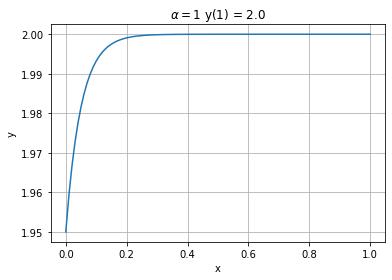

In [241]:
alpha = 1
init_sol = np.array([y0, alpha])

sol = MRK4(F, h, x_start, x_end, init_sol)
y, u = sol.T
x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
plt.plot(x, y)
plt.title(r'$\alpha = $' + f'{round(alpha, 3)} ' + f'y(1) = {round(y[-1], 3)}')
plt.ylabel('y')
plt.xlabel('x')
plt.grid()

y_L = y[-1]

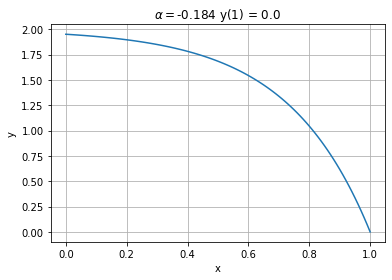

In [242]:
alpha1 = -1
alpha2 = 1

# пока что юзаем бин поиск по alpha
while (abs(y_L) > eps):
    alpha = (alpha2+alpha1)/2
    init_sol = np.array([y0, alpha])
    sol = MRK4(F, h, x_start, x_end, init_sol)
    y, u = sol.T

    assert(abs(y[0] - y0) < eps)
    assert(abs(u[0] - alpha) < eps)
    y_L = y[-1]
    if (y_L < 0):
        alpha1 = alpha
    else:
        alpha2 = alpha
    

x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
plt.plot(x, y)
plt.title(r'$\alpha = $' + f'{round(alpha, 3)} ' + f'y(1) = {round(y[-1], 3)}')
plt.ylabel('y')
plt.xlabel('x')
plt.grid()